In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as rocauc
import seaborn as sns
from time import time
import warnings
warnings.simplefilter("ignore")

In [2]:
class Pair(object):
    def __init__(self, x0, x1, y0, y1):
        """
        x0: первый элемент пары
        x1: второй элемент пары
        y0: лейбл первого элемента пары
        y1: лейбл второго элемента пары
        """
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1

        self.G = None # норма градиента
        self.c = None # константа для лосса
        
        
    def compute_gradient_norm(self, model, sess):
        """
        Считает норму градиента данной моделли а данной сессии. Возвращает число.
        """
        
        def l2_norm_of_grads_on_pair(list_of_grads):
            list_of_grads = np.concatenate([elem.flatten() for elem in list_of_grads])
            list_of_grads = list_of_grads.reshape(-1)
            return np.linalg.norm(list_of_grads)
        
        x = [self.x0] + [self.x1]
        y_ = [[self.y0]] + [[self.y1]]
        c = [[1]] * 2
        
        grads_on_pair = sess.run(model.grads, 
                                 feed_dict={model.input_layer: x,
                                            model.labels: y_,
                                            model.c: c})
        
        return l2_norm_of_grads_on_pair(grads_on_pair)

In [3]:
class Dataset(object):
    def __init__(self, X, y, test_size):
        """
        X: объекты
        y: лейблы
        test_size: доля теста для сплита на трейн/тест
        """
        [self._X_train, self.X_test,
         self._y_train, self.y_test] = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=42)
        
        self.pairs = [] # это лист, элементы которого будут Pairs
        self.pairs_n = None # это размер этого листа
        self.G = None # лист с нормами градиентов элементов self.pairs
        
    def create_train(self, predictor):
        """
        Делает из self._X_train и self._y_train пары и пишет их в self.pairs
        predictor - функция, отображает ndarray объектов в вектора, 
                    на основе которых по l2 норме будет проводиться разбиение на пары
        """
        C0_mask, C1_mask = np.all(self._y_train == 0, axis=1), np.all(self._y_train == 1, axis=1)        
        C0, C1 = self._X_train[C0_mask], self._X_train[C1_mask]
        C0_vectors, C1_vectors = predictor(C0), predictor(C1)
        C0, C1, C0_vectors, C1_vectors = list(map(lambda x: list(x), [C0, C1, C0_vectors, C1_vectors]))
        
        while len(C0) > 0 and len(C1) > 0:
            #print(len(C0),' remain')
            x0_index = 0 # будем подбираем пару для нулевого элемента C0
            norm = np.linalg.norm(np.array(C1_vectors) - C0_vectors[0], axis=1)
            x1_index = np.argmin(norm) # ему сгодится такая пара

            new_pair = Pair(C0[x0_index], C1[x1_index], 0, 1)
            self.pairs.append(new_pair) # присобачиваем полученную пару к self.pairs

            del C0[x0_index]
            del C1[x1_index]
            del C0_vectors[x0_index]
            del C1_vectors[x1_index]

        self.pairs_n = len(self.pairs)
            
    def initilize_Gs(self, model, sess):
        """
        Инициализация норм градиентов пар. 
        """
        for pair in self.pairs:
            pair.G = pair.compute_gradient_norm(model, sess)
            
        self.G = [pair.G for pair in self.pairs]

In [4]:
class NN(object):
    def __init__(self, hidden_size):
        self.input_layer = tf.placeholder(tf.float32,
                                              shape = [None, 1])
              
        self.W1 = tf.Variable(np.random.randn(1,hidden_size).astype(np.float32))
        self.b1 = tf.Variable(np.random.randn(hidden_size).astype(np.float32))
        
        self.W2 = tf.Variable(np.random.randn(hidden_size,1).astype(np.float32))
        self.b2 = tf.Variable(np.random.randn(1).astype(np.float32))
        
        self.o1 = tf.nn.relu(tf.matmul(self.input_layer, self.W1) + self.b1)
        self.logits = tf.matmul(self.o1, self.W2) + self.b2
        self.y = tf.sigmoid(self.logits)
        
        self.labels = tf.placeholder(tf.float32,
                                     shape = [None, 1])
        
        self.c = tf.placeholder(tf.float32,
                                    shape = [None, 1])
        
        self.sce = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels,
                                                           logits=self.logits)
        self.loss = tf.reduce_mean(self.sce * self.c, axis=0)       
        self.step = tf.train.AdamOptimizer().minimize(self.loss)
        
        self.trainable = [self.W1, self.W2,
                          self.b1, self.b2,]
        
        self.grads = tf.gradients(self.loss, self.trainable)
        
        
    def train_on_batch(self, pairs, sess, alpha, smart_sampling):
        """
        pairs здесь - батч пар
        """
        x = [pair.x0 for pair in pairs] + [pair.x1 for pair in pairs]
        y_ = [[pair.y0] for pair in pairs] + [[pair.y1] for pair in pairs]
        c = [[pair.c] for pair in pairs] * 2

        _, loss = sess.run([self.step, self.loss], 
                           feed_dict={self.input_layer: x,
                                      self.labels: y_,
                                      self.c: c})
        if smart_sampling == True:
            for pair in pairs:
                pair.G = (1 - alpha) * pair.G + \
                         alpha * pair.compute_gradient_norm(self, sess) 
        
        return loss
    
    def predict_on_batch(self, batch, sess):
        """
        batch здесь - обычный, не спаренный
        """
        preds = sess.run(self.y,
                         feed_dict={self.input_layer: batch})
        return preds
    
    def predict_on_ds_test(self, ds, sess, batch_size=32):
        iter_num = len(ds.X_test) // batch_size
        answer = np.array([])
        
        for i in range(iter_num):
            batch = ds.X_test[i * batch_size: (i + 1) * batch_size]
            answer = np.append(answer, self.predict_on_batch(batch, sess))
        
        if len(answer) != len(ds.X_test):
            batch = ds.X_test[iter_num * batch_size:]
            answer = np.append(answer, self.predict_on_batch(batch, sess))
    
        return answer
    
    def train_on_ds(self, ds, sess, batch_size=32, alpha=0.3, smart_sampling=False):
        losses = []
        ds.G = [pair.G for pair in ds.pairs]
        
        if smart_sampling:
            p = ds.G / sum(ds.G)
            p = np.clip(p, (1 / ds.pairs_n) / 10, (1 / ds.pairs_n) * 10)
            p /= p.sum()
        else:
            p = [1/ds.pairs_n]*ds.pairs_n
        
        for i,pair in enumerate(ds.pairs):
            pair.c = (1 / ds.pairs_n) / p[i]

        for _ in range(ds.pairs_n // batch_size):
            batch = np.random.choice(ds.pairs, size=(batch_size,), p=p)
            losses.append(self.train_on_batch(batch, sess, alpha, smart_sampling))
        return losses

In [5]:
def compute_leonid_score(model, ds, sess, a):
    """
    Возвращает 2 числа - [среднее l2 расстояние от дополнения
                           к пересечению смесей до истинного значения 
                    и 
                            среднее l2 расстояние от их
                            пересечения до истинного значения]
    """
    preds = model.predict_on_ds_test(ds, sess, batch_size=64)
    x1_a = preds[np.all(ds.X_test < 0, axis=1)]
    x1_b = preds[np.all(ds.X_test > 1, axis=1)]
    x2 = preds[np.logical_and(np.all(ds.X_test > 0, axis=1),
                              np.all(ds.X_test < 1, axis=1))]
    return [( np.abs(x1_a - 0).mean() + np.abs(x1_b - 1).mean() )/ 2,
            np.abs(x2 - 0.5).mean()]


In [6]:
a = 0.02
size = 10000

X_0 = np.random.uniform(low=-a, high=1, size=[size, 1])
X_1 = np.random.uniform(low=0, high=1 + a, size=[size, 1])
y_0 = np.zeros([size, 1])
y_1 = np.ones([size, 1])

X = np.append(X_0, X_1, axis=0)
y_ = np.append(y_0, y_1, axis=0)

In [7]:
ds = Dataset(X, y_, 0.1)
ds.create_train(lambda x: x)

In [17]:
scores_uniform_sampling = []
for i in range(15):
    t = time()
    print(i)
    scores = []
    model = NN(64)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    for _ in range(50):
        model.train_on_ds(ds, sess, batch_size=16, smart_sampling=False)
        score = compute_leonid_score(model, ds, sess, a)
        scores.append(score)
        print(_, 'complement to intersection score', score[0],
              'intersection score', score[1])
    print(time() - t)
    scores_uniform_sampling.append(scores)

0
0 complement to intersection score 0.418293183138 intersection score 0.0245467083273
1 complement to intersection score 0.440376212997 intersection score 0.0139909572728
2 complement to intersection score 0.436494116263 intersection score 0.0125428614838
3 complement to intersection score 0.42386441661 intersection score 0.0132506344473
4 complement to intersection score 0.400308124215 intersection score 0.0139686390186
5 complement to intersection score 0.412948101489 intersection score 0.0108776219688
6 complement to intersection score 0.407047323175 intersection score 0.0106678212792
7 complement to intersection score 0.368960146518 intersection score 0.0212650367144
8 complement to intersection score 0.391915212592 intersection score 0.0145225982978
9 complement to intersection score 0.368113868579 intersection score 0.0176085791968
10 complement to intersection score 0.372637887683 intersection score 0.013712718329
11 complement to intersection score 0.359054105314 intersection 

In [16]:
scores_smart_sampling = []
for i in range(15):
    t = time()
    print(i)
    scores = []
    model = NN(64)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    ds.initilize_Gs(model, sess)
    for _ in range(50):
        model.train_on_ds(ds, sess, batch_size=16, smart_sampling=True)
        score = compute_leonid_score(model, ds, sess, a)
        scores.append(score)
        print(_, 'complement to intersection score', score[0],
              'intersection score', score[1])
    print(time() - t)
    scores_smart_sampling.append(scores)

0
0 complement to intersection score 0.414900396205 intersection score 0.0298008802111
1 complement to intersection score 0.420364306254 intersection score 0.0175111887707
2 complement to intersection score 0.428410011516 intersection score 0.00985444277357
3 complement to intersection score 0.430914477728 intersection score 0.00807657193699
4 complement to intersection score 0.418289288204 intersection score 0.0136551433183
5 complement to intersection score 0.420375412136 intersection score 0.0100200024715
6 complement to intersection score 0.405117669661 intersection score 0.0122548754141
7 complement to intersection score 0.400243420946 intersection score 0.0133517861945
8 complement to intersection score 0.397780175258 intersection score 0.0123912380036
9 complement to intersection score 0.384727516325 intersection score 0.0141498399408
10 complement to intersection score 0.389612200034 intersection score 0.0134270374088
11 complement to intersection score 0.383827732025 intersect

complement to intersection score


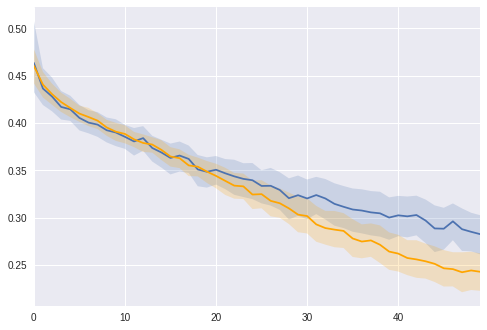

intersection score


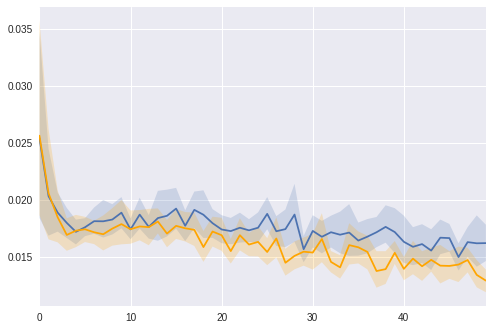

In [23]:
ci = 95
print('complement to intersection score')
sns.tsplot(data=np.array(scores_uniform_sampling)[:,:,0], ci=ci)
sns.tsplot(data=np.array(scores_smart_sampling)[:,:,0], color='orange', ci=ci)
plt.show()
print('intersection score')
sns.tsplot(data=np.array(scores_uniform_sampling)[:,:,1], ci=ci)
sns.tsplot(data=np.array(scores_smart_sampling)[:,:,1], color='orange', ci=ci)
plt.show()